# Aula 8 - Procedures, Functions e Triggers
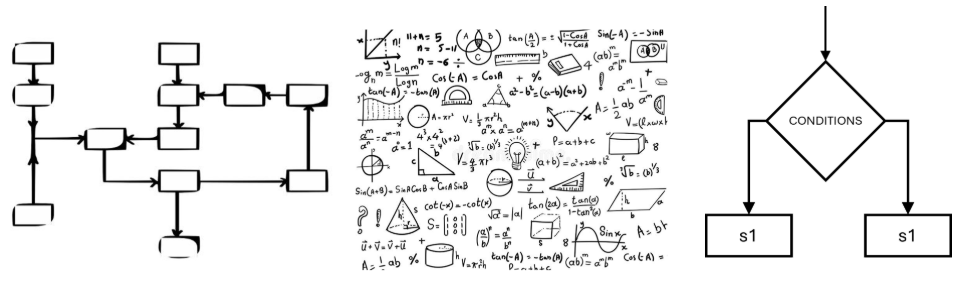

## Objetivos
- Criar e usar **Stored Procedures**, **Functions** e **Triggers** no **MySQL**.
- Conectar ao MySQL usando **PyMySQL** a partir do **Python**.
- Registrar e analisar **auditoria** de alterações (triggers).
- Visualizar resultados com **pandas** e **matplotlib**.

#### Passo 1: Importar bibliotecas

In [1]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt

#### Passo 2: Conexão ao MySQL (criando `conn` e `cursor`)

In [81]:
# 1. Criar conexão com o servidor MySQL (sem selecionar banco ainda)
conn = pymysql.connect(
    host="localhost",
    user="root",
    password="root", 
    autocommit=False  # manteremos controle explícito de commit
)
cursor = conn.cursor()
print("Conexão criada com sucesso!")

Conexão criada com sucesso!


#### Passo 3: Criar o banco de dados e selecioná-lo
**O que faremos agora:**  
1. Criar o banco `empresa_dados` (se não existir).  
2. Selecionar o banco com `USE`.  
3. Conferir qual banco está em uso.

In [3]:
cursor.execute('DROP DATABASE IF EXISTS empresa_dados')
cursor.execute('CREATE DATABASE IF NOT EXISTS empresa_dados')

1

In [83]:
cursor.execute('USE empresa_dados')

0

#### Passo 4: Criar tabelas

#### 4.1) Tabela `departamentos`
Campos principais:  
- `id` (chave primária)  
- `nome` (nome do departamento)

In [5]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS departamentos (
    id INT AUTO_INCREMENT PRIMARY KEY,
    nome VARCHAR(100) NOT NULL
);
""")
conn.commit()
print("Tabela 'departamentos' criada com sucesso!")


Tabela 'departamentos' criada com sucesso!


#### 4.2) Tabela `funcionarios`
Campos principais:  
- `id`, `nome`, `salario`, `dept_id` (chave estrangeira para `departamentos`).

In [6]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS funcionarios (
    id INT AUTO_INCREMENT PRIMARY KEY,
    nome VARCHAR(100) NOT NULL,
    salario DECIMAL(10,2) NOT NULL,
    dept_id INT,
    FOREIGN KEY (dept_id) REFERENCES departamentos(id)
);
""")
conn.commit()
print("Tabela 'funcionarios' criada com sucesso!")

Tabela 'funcionarios' criada com sucesso!


#### 4.3) Tabela `auditoria_salarios`
Finalidade: armazenar o **histórico** de alterações de salário para cada funcionário.

In [7]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS auditoria_salarios (
    id INT AUTO_INCREMENT PRIMARY KEY,
    funcionario_id INT,
    salario_antigo DECIMAL(10,2),
    salario_novo DECIMAL(10,2),
    data_alteracao TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);
""")
conn.commit()
print("Tabela 'auditoria_salarios' criada com sucesso!")

Tabela 'auditoria_salarios' criada com sucesso!



## 5) Inserir dados de exemplo
**O que faremos agora:**  
- Inserir alguns departamentos e funcionários para podermos testar nossas rotinas.


In [9]:
departamentos = [
    ("dados",),
    ("TI",),
    ("Financeiro",),
    ("RH",)
]
cursor.executemany('INSERT INTO departamentos (nome) VALUES (%s)',departamentos)
conn.commit()

In [13]:
funcionarios = [
    ("Gaby",1000,1),
    ("Amanda",1000,2),
    ("Karol",1000,3),
    ("Giovana",1000,4),
    ("Emily",1200,1)
]
cursor.executemany("""INSERT INTO funcionarios (nome, salario, dept_id) 
VALUES (%s,%s,%s)""", funcionarios)
conn.commit()


### 5.1) Visualizar os dados atuais dos funcionários
**O que faremos agora:**  
- Executar um `SELECT` e visualizar o resultado em um DataFrame do `pandas`.


In [14]:
cursor.execute('SELECT * FROM funcionarios ORDER BY id;')
pd.DataFrame(cursor.fetchall(),columns=["id","nome","salario","dept_ID"])

,id,nome,salario,dept_ID
0,1,Gaby,1000.00,1
1,2,Amanda,1000.00,2
2,3,Karol,1000.00,3
3,4,Giovana,1000.00,4
4,5,Emily,1200.00,1



## 6) Stored Procedures — exemplos práticos
As **procedures** são rotinas armazenadas que executam tarefas no servidor MySQL.



### 6.1) Procedure `listar_funcionarios()`
**Objetivo:** retornar todos os funcionários.  
> **Importante:** no MySQL Workbench usa-se `DELIMITER`, mas aqui estamos executando via driver Python, que aceita o bloco diretamente.


In [19]:
cursor.execute('DROP PROCEDURE IF EXISTS listar_funcionarios')
cursor.execute("""
CREATE PROCEDURE listar_funcionarios()
BEGIN
    SELECT * FROM funcionarios ORDER BY id;
END;
""")
conn.commit()

In [20]:
cursor.callproc('listar_funcionarios')
cursor.fetchall()

((1, 'Gaby', Decimal('1000.00'), 1),
 (2, 'Amanda', Decimal('1000.00'), 2),
 (3, 'Karol', Decimal('1000.00'), 3),
 (4, 'Giovana', Decimal('1000.00'), 4),
 (5, 'Emily', Decimal('1200.00'), 1))


### 6.2) Procedure `funcionarios_por_departamento(IN p_dept INT)`
**Objetivo:** listar funcionários de um departamento específico, com nome do departamento.


In [26]:
cursor.execute('DROP PROCEDURE IF EXISTS lfuncionarios_por_departamento')
cursor.execute("""
CREATE PROCEDURE funcionarios_por_departamento(IN p_dept INT)
BEGIN
    SELECT f.id, f.nome, f.salario, d.nome AS departamento
    FROM funcionarios f
    LEFT JOIN departamentos d ON d.id = f.dept_id
    WHERE f.dept_id = p_dept
    ORDER BY f.salario DESC;

END;
""")
conn.commit()

In [27]:
args = (1,)
cursor.callproc('funcionarios_por_departamento', args)
cursor.fetchall()

((5, 'Emily', Decimal('1200.00'), 'dados'),
 (1, 'Gaby', Decimal('1000.00'), 'dados'))


### 6.3) Procedure `reajuste_salario(IN p_fator DECIMAL)`
**Objetivo:** multiplicar os salários pelo fator informado (ex.: `1.10` = +10%).


In [28]:
cursor.execute("DROP PROCEDURE IF EXISTS reajuste_salario;")
cursor.execute("""
CREATE PROCEDURE reajuste_salario(IN p_fator DECIMAL(5,4))
BEGIN
    UPDATE funcionarios SET salario = ROUND(salario * p_fator,2);
END;
""")
conn.commit()

In [29]:
args = (1.10,)
cursor.callproc('reajuste_salario',args)
conn.commit()

In [30]:
cursor.execute('SELECT * FROM funcionarios ORDER BY id;')
pd.DataFrame(cursor.fetchall(),columns=["id","nome","salario","dept_ID"])

,id,nome,salario,dept_ID
0,1,Gaby,1100.00,1
1,2,Amanda,1100.00,2
2,3,Karol,1100.00,3
3,4,Giovana,1100.00,4
4,5,Emily,1320.00,1



## 7) Functions — cálculos reutilizáveis
As **functions** retornam **um valor** e podem ser usadas em `SELECT`, `WHERE`, `ORDER BY` etc.



### 7.1) Função `calcular_bonus(p_salario)`
**Objetivo:** retornar 15% do salário.


In [31]:
cursor.execute("DROP PROCEDURE IF EXISTS calcular_bonus;")
cursor.execute("""
CREATE FUNCTION calcular_bonus(p_salario DECIMAL(10,2)) RETURNS DECIMAL (10,2)
DETERMINISTIC
BEGIN
    DECLARE v_bonus DECIMAL(10,2);
    SET v_bonus = ROUND(p_salario * 0.15,2);
    RETURN v_bonus;
    
END;
""")
conn.commit()

In [32]:
cursor.execute(""" SELECT nome,salario,calcular_bonus(salario)
AS bonus FROM funcionarios ORDER BY salario DESC;""")
pd.DataFrame(cursor.fetchall(),columns = ["Nome","Salario","Bonus"])

,Nome,Salario,Bonus
0,Emily,1320.00,198.00
1,Gaby,1100.00,165.00
2,Amanda,1100.00,165.00
3,Karol,1100.00,165.00
4,Giovana,1100.00,165.00



### 7.2) Função `classificar_salario(p_valor)`
**Objetivo:** classificar em **Baixo**, **Médio** ou **Alto**.


In [34]:
cursor.execute('DROP FUNCTION IF EXISTS classificar_salario')
cursor.execute("""
CREATE FUNCTION classificar_salario(p_valor DECIMAL(10,2)) RETURNS VARCHAR(20)
DETERMINISTIC
BEGIN
    DECLARE v_cat VARCHAR(20);
    IF p_valor < 3000 THEN
        SET v_cat = 'Baixo';
    ELSEIF p_valor BETWEEN 3000 AND 15000 THEN
        SET v_cat = 'Medio';
    ELSE  
        SET v_cat = 'Alto';
    END IF;
    RETURN v_cat;
END;
""")
conn.commit()

In [37]:
cursor.execute("""SELECT nome, salario, classificar_salario(salario)
AS faixa FROM funcionarios ORDER BY salario """)
pd.DataFrame(cursor.fetchall(), columns = ['nome','salario','faixa'])

,nome,salario,faixa
0,Gaby,1100.00,Baixo
1,Amanda,1100.00,Baixo
2,Karol,1100.00,Baixo
3,Giovana,1100.00,Baixo
4,Emily,1320.00,Baixo



## 8) Triggers — auditoria e validação
As **triggers** reagem automaticamente a eventos (INSERT/UPDATE/DELETE).



### 8.1) Trigger de auditoria (após UPDATE)
**Objetivo:** quando o salário mudar, registrar no log `auditoria_salarios`.


In [46]:
cursor.execute('DROP TRIGGER IF EXISTS trg_auditor_salario;')
cursor.execute("""
CREATE TRIGGER trg_auditor_salario
AFTER UPDATE ON funcionarios
FOR EACH ROW
BEGIN
    IF OLD.salario <> NEW.salario THEN
        INSERT INTO auditoria_salarios(funcionario_id, salario_antigo, salario_novo)
        VALUES (OLD.id, OLD.salario, NEW.salario);
    END IF;
END;
""")
conn.commit()


### 8.2) Trigger de validação (antes do UPDATE)
**Objetivo:** bloquear aumentos **maiores que 50%**.


In [39]:
cursor.execute('DROP TRIGGER IF EXISTS trg_validar_reajuste;')
cursor.execute("""
CREATE TRIGGER trg_validar_reajuste
AFTER UPDATE ON funcionarios
FOR EACH ROW
BEGIN
    IF NEW.salario > OLD.salario * 1.5 THEN
        SIGNAL SQLSTATE '45000' SET MESSAGE_TEXT = 'Aumento acima de 50% - não permitido';
    END IF;
END;
""")
conn.commit()


## 9) Testes dos mecanismos (reajuste + auditoria + validação)
**O que faremos agora:**  
1. Aplicar um reajuste **de 5%** usando a procedure.  
2. Conferir os registros de **auditoria**.  
3. Testar um aumento proibido (**> 50%**) e ver a mensagem de erro.


In [47]:
arg = (1.05,)
cursor.callproc('reajuste_salario',arg)
conn.commit()

In [49]:
cursor.execute('SELECT * FROM auditoria_salarios')
columns=['id','id_funcionario','salario_antigo','salario_novo','data_modificação']
pd.DataFrame(cursor.fetchall(), columns=columns)

,id,id_funcionario,salario_antigo,salario_novo,data_modificação
0,1,1,1100.00,1155.00,2025-10-09 21:20:18
1,2,2,1100.00,1155.00,2025-10-09 21:20:18
2,3,3,1100.00,1155.00,2025-10-09 21:20:18
3,4,4,1100.00,1155.00,2025-10-09 21:20:18
4,5,5,1320.00,1386.00,2025-10-09 21:20:18


In [53]:
try:
    cursor.execute('UPDATE funcionarios SET salario = salario * 1.51 WHERE id= 1;')
    conn.commit()
    print('Atualização aplicada!')
except Exception as e:
    conn.rollback()
    print('Erro esperado da trigger:', e)

Erro esperado da trigger: (1644, 'Aumento acima de 50% - não permitido')



## 10) Visualizações com `pandas` + `matplotlib`
Vamos criar três gráficos simples para comunicar resultados:
1. **Barras:** alterações por funcionário.  
2. **Linha:** alterações por dia.  
3. **Barras:** média salarial por departamento.


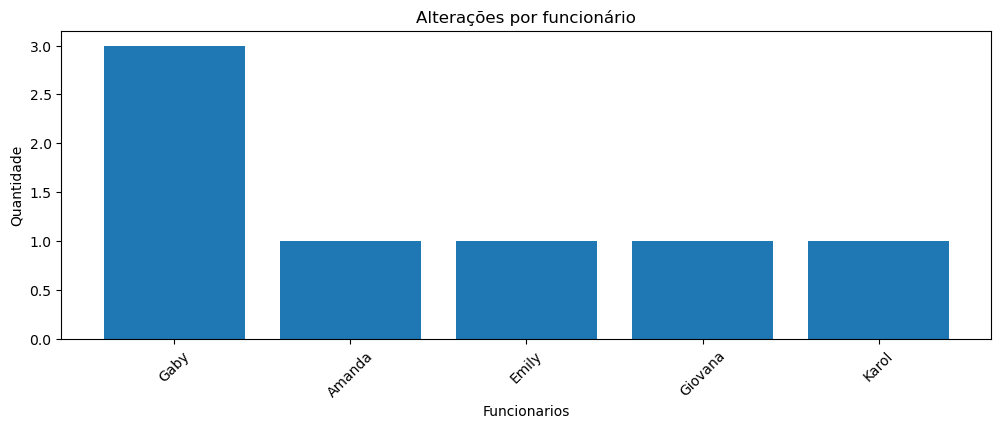

In [73]:
cursor.execute("""
    SELECT f.nome, COUNT(a.id) AS qtd
    FROM funcionarios f
    LEFT JOIN auditoria_salarios a ON a.funcionario_id = f.id
    GROUP BY f.id, f.nome
    ORDER BY qtd DESC, f.nome
""")

df_qtd = pd.DataFrame(cursor.fetchall(), columns = ['nome', 'qtd'])
plt.figure(figsize=(12,4))
plt.bar(df_qtd['nome'],df_qtd['qtd'])
plt.title('Alterações por funcionário')
plt.xlabel('Funcionarios')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.show()

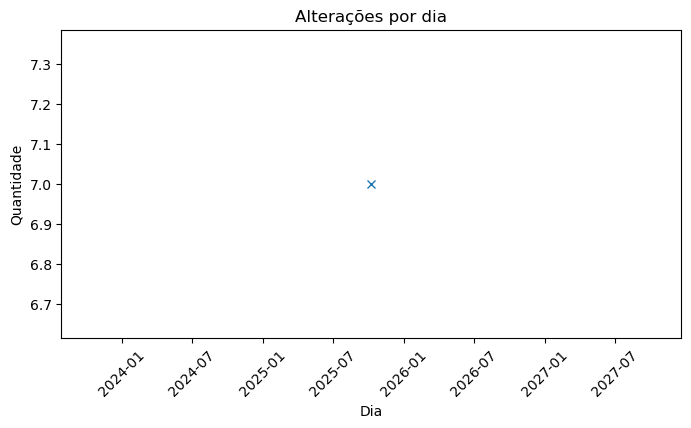

In [69]:
cursor.execute("""
    SELECT DATE(data_alteracao) AS dia, COUNT(*) AS qtd
    FROM auditoria_salarios
    GROUP BY DATE(data_alteracao)
    ORDER BY dia
""")
df_tempo = pd.DataFrame(cursor.fetchall(), columns = ['dia', 'qtd'])
plt.figure(figsize=(8,4))
plt.plot(df_tempo['dia'],df_tempo['qtd'], marker='x')
plt.title('Alterações por dia')
plt.xlabel('Dia')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.show()

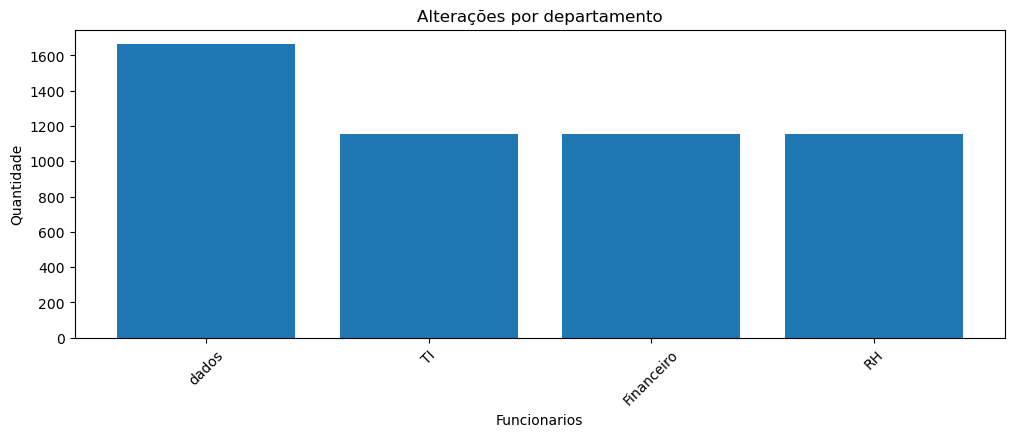

In [71]:
cursor.execute("""
    SELECT d.nome AS departamento, ROUND(AVG(f.salario),2) AS media
    FROM funcionarios f
    LEFT JOIN departamentos d ON d.id = f.dept_id
    GROUP BY d.id, d.nome
    ORDER BY media DESC
""")

df_med = pd.DataFrame(cursor.fetchall(), columns = ['departamento', 'media'])
plt.figure(figsize=(12,4))
plt.bar(df_med['departamento'],df_med['media'])
plt.title('Alterações por departamento')
plt.xlabel('Funcionarios')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.show()


## 11) Exercícios propostos
1. **Procedure** `add_funcionario(IN p_nome, IN p_salario, IN p_dept)` que insere e emite `SELECT LAST_INSERT_ID()` para retornar o novo `id` ao Python.  
2. **Function** `calc_imposto(p_salario)` (10%) e consulta com salário líquido.  
3. **Trigger** que bloqueia **redução** maior que 30% do salário.  
4. **Relatório**: `nome, departamento, salario, bonus, faixa` ordenado por `bonus` (use as funções).


### Exercício 1 — Procedure add_funcionario

Crie uma procedure chamada add_funcionario que receba como entrada:
- `p_nome` (nome do funcionário)
- `p_salario` (valor do salário)
- `p_dept` (departamento)

E retorne via **OUT** o `ID` do **funcionário recém-inserido**.

In [74]:
cursor.execute("DROP PROCEDURE IF EXISTS add_funcionario;")
cursor.execute("""
CREATE PROCEDURE add_funcionario(
    IN p_nome VARCHAR(100),
    IN p_salario DECIMAL(10,2),
    IN p_dept INT,
    OUT p_id INT
)
BEGIN
    INSERT INTO funcionarios(nome, salario, dept_id)
    VALUES (p_nome, p_salario, p_dept);
    SET p_id = LAST_INSERT_ID();
END;
""")
conn.commit()
nome = "Gaby"
salario = 1500
departamento = 2
cursor.execute("SET @novo_id = 0;")
cursor.execute("CALL add_funcionario(%s, %s, %s, @novo_id);", (nome, salario, departamento))
cursor.execute("SELECT @novo_id;")
novo_id = cursor.fetchone()[0]

print(f"ID do novo funcionário: {novo_id}")

ID do novo funcionário: 6


### Exercício 2 — Function calc_imposto

Crie uma função chamada `calc_imposto(p_salario)` que retorne o valor do **salário líquido**, descontando **10% de imposto**.

In [77]:
def calc_imposto(p_salario):
    """
    Recebe o salário bruto e retorna o salário líquido
    descontando 10% de imposto.
    """
    imposto = p_salario * 0.10 
    salario_liquido = p_salario - imposto
    return salario_liquido
salario = 2000
print(f"Salário líquido: R$ {calc_imposto(salario):.2f}")

Salário líquido: R$ 1800.00


### Exercício 3 — Trigger trg_validar_reducao

Crie uma trigger chamada `trg_validar_reducao` que impede reduções maiores que 30% no salário de um funcionário.

In [84]:
# --- 1️⃣ Remover a trigger se já existir ---
cursor.execute("DROP TRIGGER IF EXISTS trg_validar_reducao;")

# --- 2️⃣ Criar a trigger ---
cursor.execute("""
CREATE TRIGGER trg_validar_reducao
BEFORE UPDATE ON funcionarios
FOR EACH ROW
BEGIN
    IF NEW.salario < OLD.salario * 0.7 THEN
        SIGNAL SQLSTATE '45000'
        SET MESSAGE_TEXT = 'Redução de salário maior que 30% não é permitida';
    END IF;
END;
""")

# --- 3️⃣ Confirmar a criação ---
conn.commit()
print("Trigger trg_validar_reducao criada com sucesso!")

Trigger trg_validar_reducao criada com sucesso!


### Exercício 4 — Relatório combinado

Crie uma consulta que mostre:
- `nome`, `departamento`, `salario`,
- `bonus` (usando `calcular_bonus`),
- `faixa` (usando `classificar_salario`),
- `salario_liquido` (usando `calc_imposto`)

In [86]:
cursor = conn.cursor()

# Criar função diretamente
cursor.execute("""
CREATE FUNCTION IF NOT EXISTS calc_imposto(p_salario DECIMAL(10,2))
RETURNS DECIMAL(10,2)
DETERMINISTIC
BEGIN
    RETURN p_salario * 0.9; -- desconta 10%
END
""")

conn.commit()
print("Função calc_imposto criada com sucesso!")

# Agora você pode executar a consulta combinada
query = """
SELECT 
    f.nome,
    d.nome AS departamento,
    f.salario,
    calcular_bonus(f.salario) AS bonus,
    classificar_salario(f.salario) AS faixa,
    calc_imposto(f.salario) AS salario_liquido
FROM 
    funcionarios f
JOIN 
    departamentos d ON f.dept_id = d.id
ORDER BY 
    f.id;
"""

cursor.execute(query)
colunas = [desc[0] for desc in cursor.description]
import pandas as pd
df = pd.DataFrame(cursor.fetchall(), columns=colunas)

print(df)

Função calc_imposto criada com sucesso!
      nome departamento  salario   bonus  faixa salario_liquido
0     Gaby        dados  1940.40  291.06  Baixo         1746.36
1   Amanda           TI  1155.00  173.25  Baixo         1039.50
2    Karol   Financeiro  1155.00  173.25  Baixo         1039.50
3  Giovana           RH  1155.00  173.25  Baixo         1039.50
4    Emily        dados  1386.00  207.90  Baixo         1247.40



## 12) Encerrar a conexão
**O que faremos agora:**  
- Fechar `cursor` e `conn` ao final do notebook.


In [87]:
cursor.close()
conn.close()